## Convocatoria 1 - Proyecto 1

**Nombre y apellidos:** Alexandre Carulla Rodes

**Fecha de entrega:** 04/08/2025

In [3]:
# Importación de los módulos empleados
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cv2
from skimage import io
from skimage.morphology import remove_small_objects
from skimage.segmentation import flood
from scipy.ndimage import binary_fill_holes
from skimage.measure import label, regionprops

#### 0) Cargar una de las imágenes histológicas

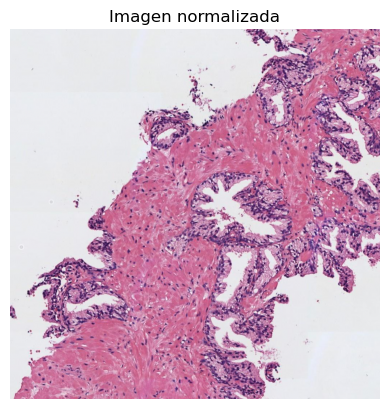

In [5]:
# Lectura de la imagen a analizar
image = io.imread('histo_1.jpg')

# Normalización de los píxeles de la imagen
image_norm = image / 255

# Representación de la imagen
plt.imshow(image_norm)
plt.title('Imagen normalizada')
plt.axis('off')
plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

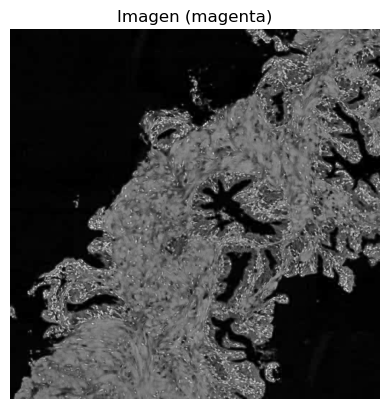

In [7]:
image_rgb = image_norm.copy()

# Operaciones para la transformación al espacio de color CMYK
with np.errstate(invalid='ignore', divide='ignore'):
    K = 1 - np.max(image_rgb, axis=2)
    C = (1 - image_rgb[:, :, 0] - K) / (1 - K)
    M = (1 - image_rgb[:, :, 1] - K) / (1 - K)
    Y = (1 - image_rgb[:, :, 2] - K) / (1 - K)
CMYK = (np.dstack((C, M, Y, K)) * 255).astype('uint8')

# Representación del canal magenta de la imagen
plt.imshow(M, cmap='gray')
plt.title('Imagen (magenta)')
plt.axis('off')
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

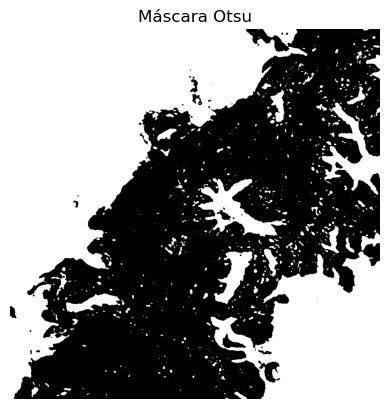

In [9]:
# Filtro gaussiano (5×5) para tener más superficie de trabajo y obtener mejores resultados
M_smooth = cv2.GaussianBlur((M * 255).astype('uint8'), (5, 5), 0)

# Método Otsu para determinar los umbrales de forma automática
t, mask = cv2.threshold(M_smooth, 0, 1, cv2.THRESH_OTSU)
mask = 1 - mask # Para que valga '1' aquellos píxeles correspondientes al lumen y el fondo, y '0' el resto.

# Representación de la máscara Otsu
plt.imshow(mask, cmap='gray')
plt.title('Máscara Otsu')
plt.axis('off')
plt.show()

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

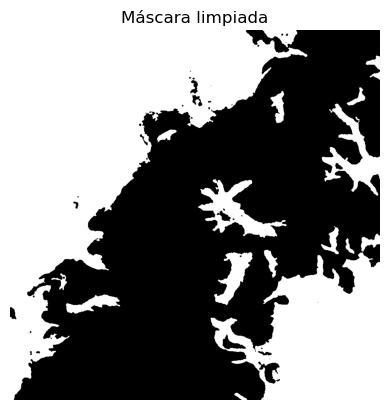

In [11]:
# Eliminación de pequeños objetos presentes en la máscara con área menor a 300 píxeles
mask_clean = remove_small_objects(mask.astype(bool), min_size=300) # Según la documentación, min_size está deprecated en versiones actuales
mask_clean = mask_clean.astype('uint8')

# Representacióon de la máscara nueva limpiada
plt.imshow(mask_clean, cmap='gray')
plt.title('Máscara limpiada')
plt.axis('off')
plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

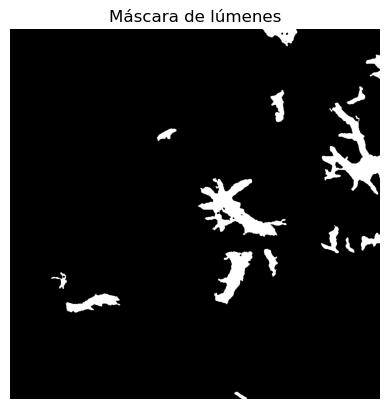

In [13]:
mask_clean_scaled = (mask_clean * 255).copy()

# Máscara auxiliar con '0' para el algoritmo de expansión
h, w = mask_clean_scaled.shape
mask_zeros = np.zeros((h+2, w+2), np.uint8) # Se da un píxel extra de margen en cada lado

# Rellenado de regiones (algoritmo de expansión) con '0' para que solo los lúmenes queden de color blanco
seed1 = (0, 0) # Primera semilla
seed2 = (h - 1, w - 1) # Segunda semilla
cv2.floodFill(mask_clean_scaled, mask_zeros, seed1, 0)
cv2.floodFill(mask_clean_scaled, mask_zeros, seed2, 0)

mask_final = (mask_clean_scaled / 255).copy()

# Representación de la máscara de lúmenes
plt.imshow(mask_final, cmap='gray')
plt.title("Máscara de lúmenes")
plt.axis('off')
plt.show()

#### 5) Rellenar los objetos de los lúmenes

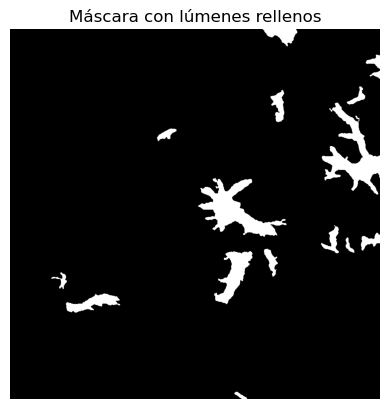

In [15]:
# Rellenado de los huecos internos de los lúmenes
mask_final_filled = binary_fill_holes(mask_final).astype(np.uint8)

# Representación de la máscara de lúmenes rellenada
plt.imshow(mask_final_filled, cmap='gray')
plt.title('Máscara con lúmenes rellenos')
plt.axis('off')
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

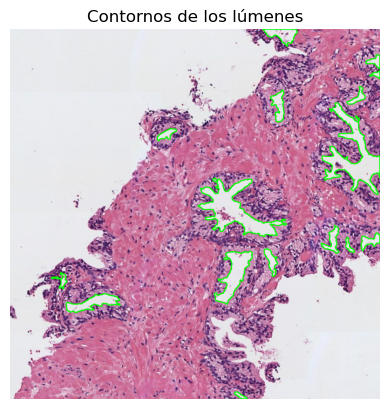

In [17]:
# Detección de los contornos externos de los lúmenes
contours, _ = cv2.findContours(mask_final_filled * 255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dibujo de los contornos sobre la imagen original
image_contours = image.copy()
cv2.drawContours(image_contours, contours, -1, (0, 255, 0), thickness=2)

# Representación de la imagen con los contornos (lúmenes)
plt.imshow(image_contours)
plt.title('Contornos de los lúmenes')
plt.axis('off')
plt.show()

#### 7) Identificar y cropear el lumen más grande

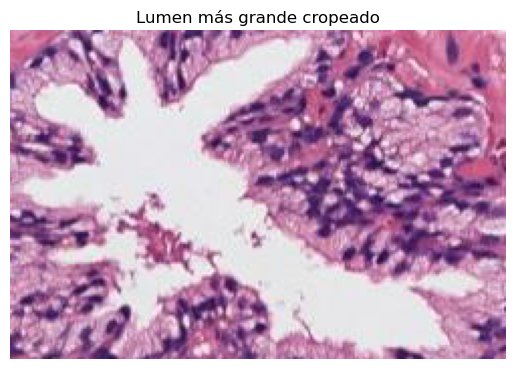

In [19]:
# Etiquetado de los objetos conectados en la máscara obtenida
labeled_mask = label(mask_final_filled)

# Obtención de las propiedades de cada región
regions = regionprops(labeled_mask)

# Búsqueda del lumen más grande entre las regiones obtenidas
max_area = 0
max_region = None
for region in regions:
    if region.area > max_area:
        max_area = region.area
        max_region = region

# Obtención de la bounding box del lumen más grande
minr, minc, maxr, maxc = max_region.bbox

# Crop de la imagen original sobre el lumen más grande
lumen_crop = image_norm[minr:maxr, minc:maxc, :]

# Representación del lumen más grande encontrado
plt.imshow(lumen_crop)
plt.title('Lumen más grande cropeado')
plt.axis('off')
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [21]:
# Caracterización para el lumen más grande
area = round(max_region.area, 4)
bbox_area = round(max_region.bbox_area, 4)
convex_area = round(max_region.convex_area, 4)
eccentricity = round(max_region.eccentricity, 4)
equiv_diameter = round(max_region.equivalent_diameter, 4)
extent = round(max_region.extent, 4)
major_axis_length = round(max_region.major_axis_length, 4)
minor_axis_length = round(max_region.minor_axis_length, 4)
orientation = round(max_region.orientation, 4)
perimeter = round(max_region.perimeter, 4)
solidity = round(max_region.solidity, 4)
compactness = round(4 * np.pi * area / (perimeter ** 2), 4)

minr, minc, maxr, maxc = max_region.bbox
feret_diameter = round(np.sqrt((maxr - minr)**2 + (maxc - minc)**2), 4) # El diámetro de Feret es la diagonal máxima de la bounding box

# Estructuración de los resultados en formato de serie
features = pd.Series({
    "Área": area,
    "Área Bounding Box": bbox_area,
    "Área Convexa": convex_area,
    "Excentricidad": eccentricity,
    "Diámetro Equivalente": equiv_diameter,
    "Extensión": extent,
    "Diámetro Feret": feret_diameter,
    "Longitud Eje Mayor": major_axis_length,
    "Longitud Eje Menor": minor_axis_length,
    "Orientación": orientation,
    "Perímetro": perimeter,
    "Solidez": solidity,
    "Compacidad": compactness
})
display(features)

Área                    14075.0000
Área Bounding Box       40098.0000
Área Convexa            29283.0000
Excentricidad               0.8478
Diámetro Equivalente      133.8688
Extensión                   0.3510
Diámetro Feret            295.1017
Longitud Eje Mayor        238.6358
Longitud Eje Menor        126.5495
Orientación                 1.0058
Perímetro                1242.5971
Solidez                     0.4807
Compacidad                  0.1146
dtype: float64